# Face detection on the basis of age, gender and ethnicity

## Importing essential libraries

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

Loading a dataset

In [108]:
data = pd.read_csv("../input/age-gender-and-ethnicity-face-data-csv/age_gender.csv")
data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


## Analyzing and cleaning the data

In [109]:
df = data.drop('img_name', axis=1)
df.head()

,age,ethnicity,gender,pixels
0,1,2,0,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,202 205 209 210 209 209 210 211 212 214 218 21...


In [110]:
def basic_eda(df):
    print("\n Shape: ")
    print(df.shape)
    print("\n\n --------- ")
    print("\n Number of null values: ")
    print(df.isnull().sum())
    print("\n\n --------- ")
    print("\n Value count of age: ")
    print(df['age'].value_counts())
    print("\n\n --------- ")
    print("\n Value count of ethnicity: ")
    print(df['ethnicity'].value_counts())
    print("\n\n --------- ")
    print("\n Value count of gender: ")
    print(df['gender'].value_counts())

In [111]:
basic_eda(df)


 Shape: 
(23705, 4)


 --------- 

 Number of null values: 
age          0
ethnicity    0
gender       0
pixels       0
dtype: int64


 --------- 

 Value count of age: 
age
26     2197
1      1123
28      918
35      880
24      859
       ... 
115       3
101       2
91        2
103       1
111       1
Name: count, Length: 104, dtype: int64


 --------- 

 Value count of ethnicity: 
ethnicity
0    10078
1     4526
3     3975
2     3434
4     1692
Name: count, dtype: int64


 --------- 

 Value count of gender: 
gender
0    12391
1    11314
Name: count, dtype: int64


In [112]:
# Dividing target variables
columns = ["age", "gender", "ethnicity"]
y = df.drop("pixels", axis=1)
X = df.drop(columns, axis=1)

In [113]:
X.head()

,pixels
0,129 128 128 126 127 130 133 135 139 142 145 14...
1,164 74 111 168 169 171 175 182 184 188 193 199...
2,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,193 197 198 200 199 200 202 203 204 205 208 21...
4,202 205 209 210 209 209 210 211 212 214 218 21...


In [114]:
y.head()

,age,ethnicity,gender
0,1,2,0
1,1,2,0
2,1,2,0
3,1,2,0
4,1,2,0


In [115]:
y.nunique()

age          104
ethnicity      5
gender         2
dtype: int64

## Data distribution with visualization

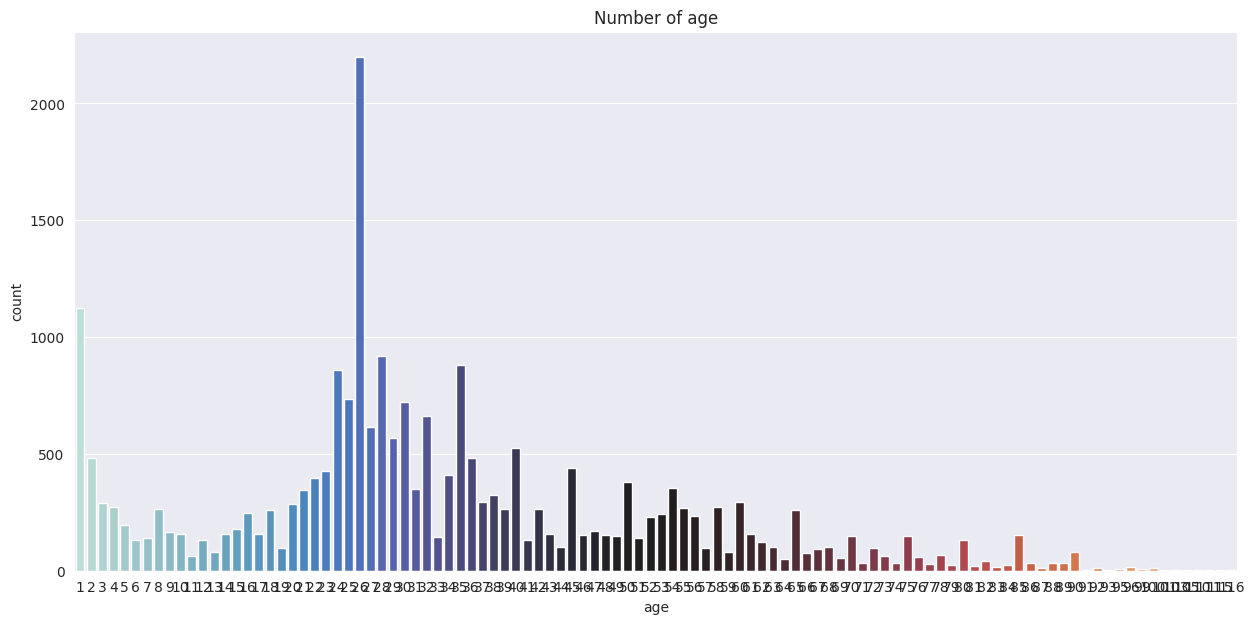

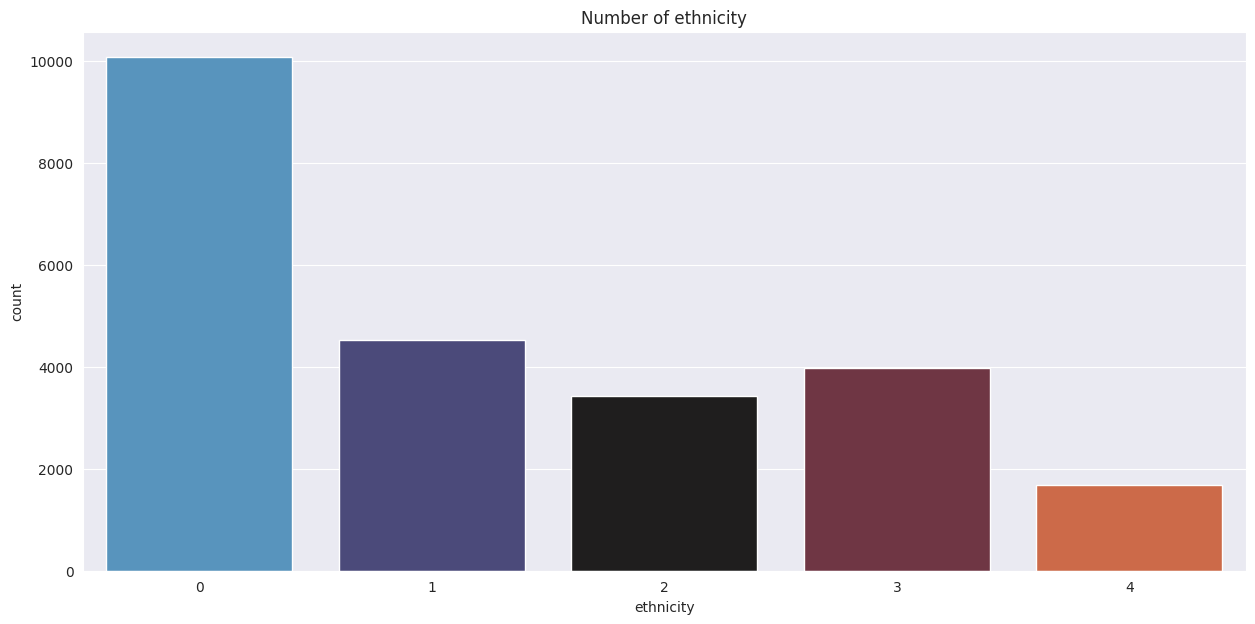

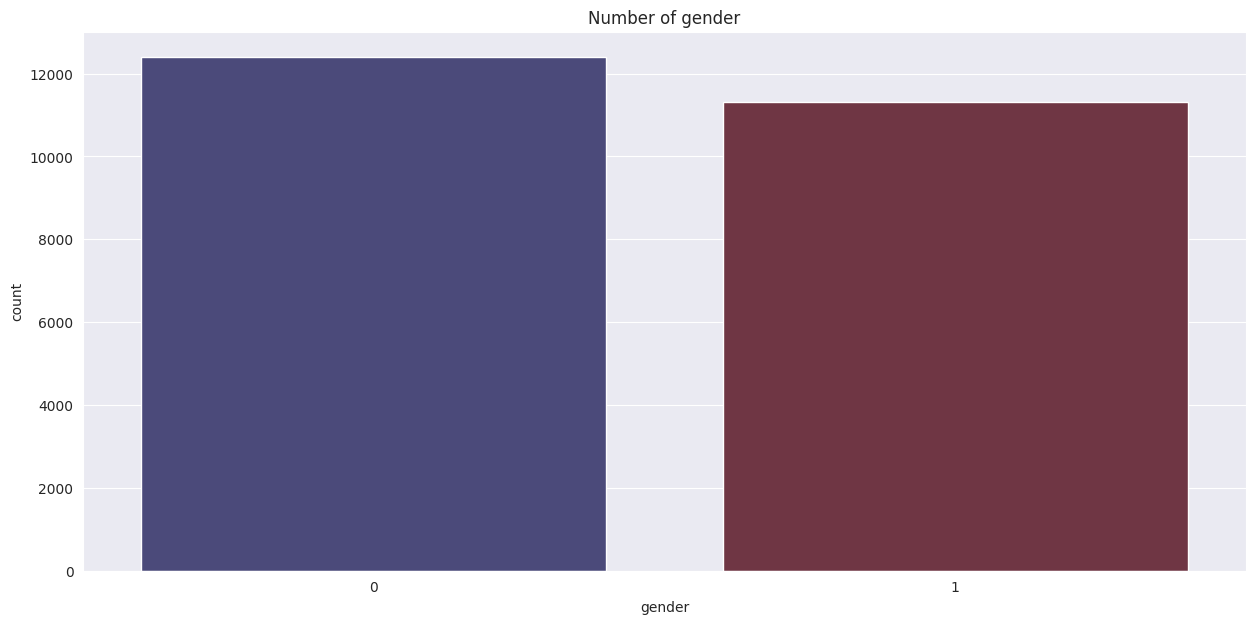

In [116]:
for i in y.columns:
    plt.figure(figsize=(15, 7))
    g = sns.countplot(x=y[i], palette="icefire")
    plt.title("Number of {}".format(i))
    plt.show()

Text(0.5, 1.0, 'Number of age')

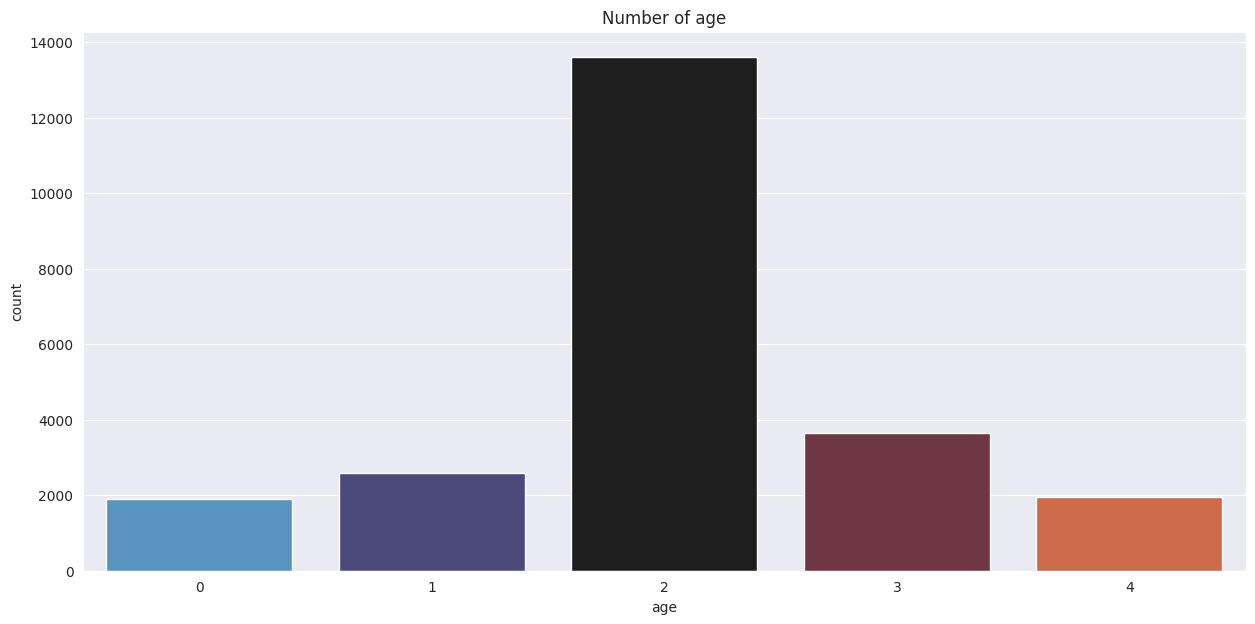

In [117]:
y["age"] = pd.cut(y["age"],bins=[0,3,18,45,64,116],labels=["0","1","2","3","4"])
plt.figure(figsize=(15,7))
g = sns.countplot(x=y["age"], palette="icefire")
plt.title("Number of age")

## Image shape

In [118]:
num_pixels = len(X['pixels'][0].split(" "))
img_height = int(np.sqrt(len(X['pixels'][0].split(" "))))
img_width = int(np.sqrt(len(X['pixels'][0].split(" "))))
print(num_pixels, img_height, img_width)


2304 48 48


## Reshape data

In [119]:
X = pd.Series(X['pixels'])

def convert_to_array(pixel_string):
    try:
        return np.array(list(map(int, pixel_string.split(' '))))
    except ValueError:
        return None  # or handle the error in a way that's appropriate for your data

X = X.apply(convert_to_array)
X = X.dropna()
X = np.stack(X.values, axis=0)
try:
    X = X.reshape(-1, 48, 48, 1)
    print("X shape: ", X.shape)
except ValueError as e:
    print(f"Reshape error: {e}")

X shape:  (23705, 48, 48, 1)


## Image Overview

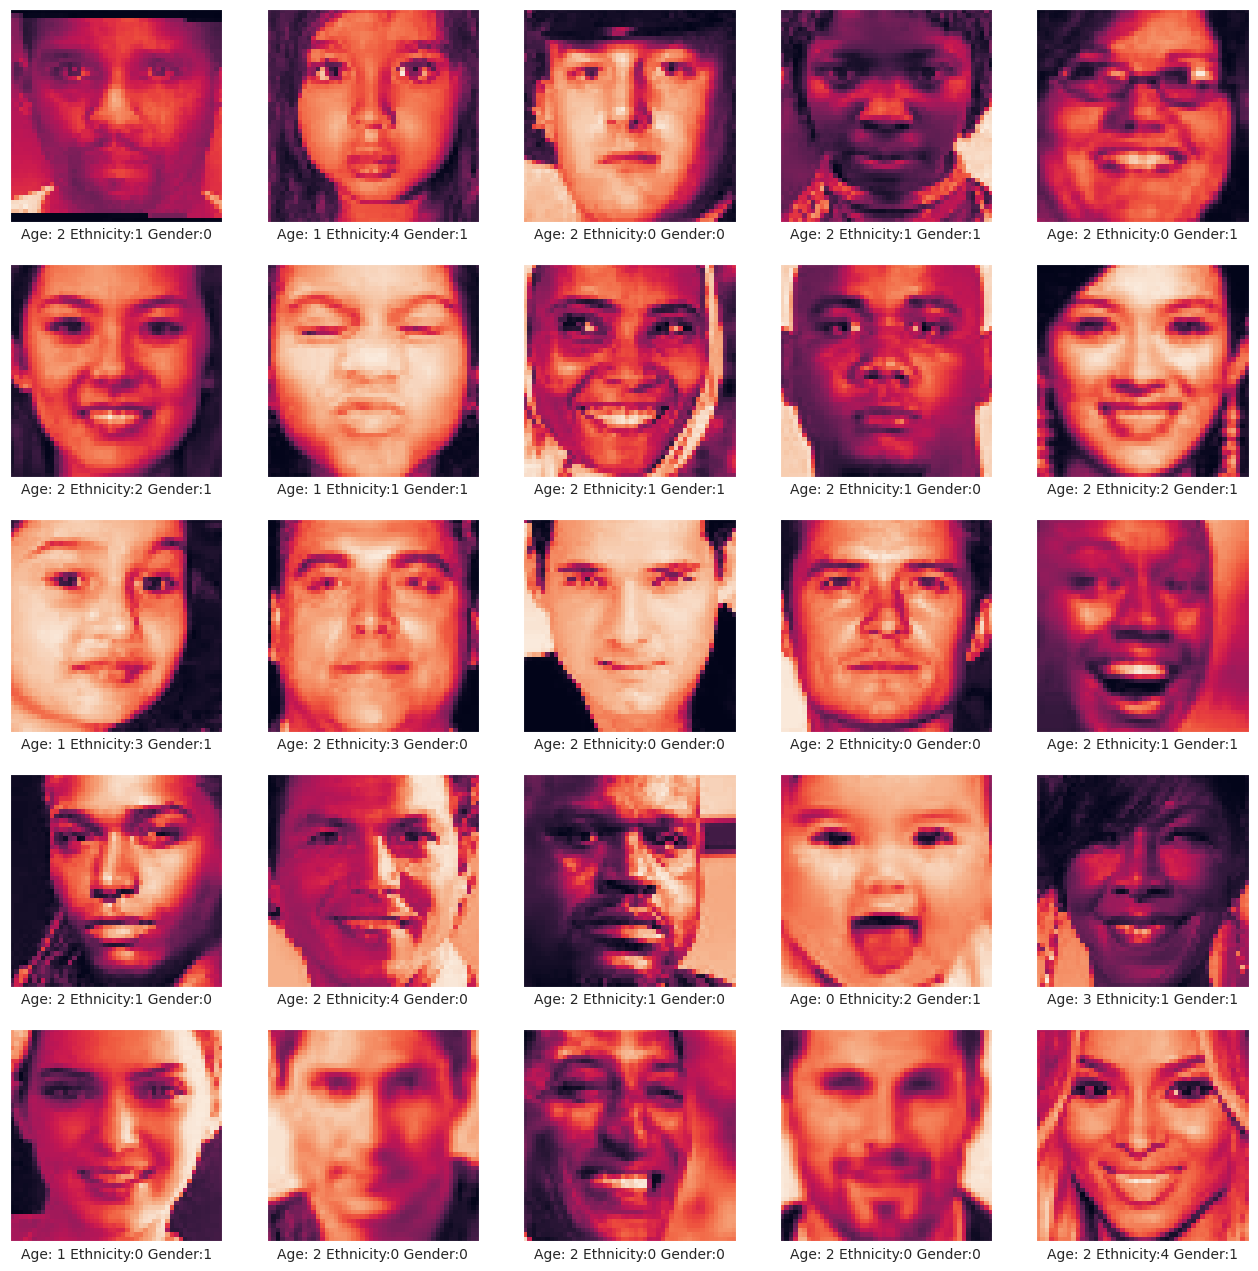

In [120]:
plt.figure(figsize=(16,16))
for i,a in zip(np.random.randint(0, 23705, 25), range(1,26)):
    plt.subplot(5,5,a)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i])
    plt.xlabel(
    "Age: "+str(y['age'].iloc[i])+
    " Ethnicity:"+str(y['ethnicity'].iloc[i])+
    " Gender:"+str(y['gender'].iloc[i]))
plt.show()

## Building Neural Networks for AGE, GENDER AND ETHNICITY

In [121]:
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf
import plotly.express as px
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, InputLayer
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy

## Categorizing target values

In [123]:
age_matrix = np.array(y['age'])
gender_matrix = np.array(y['gender'])
ethnicity_matrix = np.array(y['ethnicity'])
age = to_categorical(age_matrix, num_classes = 5)
gender = to_categorical(y["gender"], num_classes = 2)
ethnicity = to_categorical(ethnicity_matrix, num_classes = 5)
print(age, gender, ethnicity)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]] [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] [[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]


##  Normalize the data

In [124]:
X = X / 255
X = X / 255

## Image Data Generator

In [125]:
atagen = ImageDataGenerator(
        featurewise_center = False,
    # set input mean to 0 over the dataset
       samplewise_center = False,
    # set each sample mean to 0 
       featurewise_std_normalization = False,
    # divide inputs by std of the dataset
       samplewise_std_normalization=False,  
    # divide each input by its std
       zca_whitening=False,
    # dimesion reduction
       rotation_range=5, 
    # randomly rotate images in the range 5 degrees
       zoom_range = 0.1,
    # Randomly zoom image 10%
       width_shift_range=0.1, 
    # randomly shift images horizontally 10%
       height_shift_range=0.1,  
    # randomly shift images vertically 10%
       horizontal_flip=False,  
    # randomly flip images
        vertical_flip=False  # randomly flip images
)

datagen.fit(X)

## Train Test Split

In [126]:
# Ethnicity
from sklearn.model_selection import train_test_split
X_train_ethnicity, X_test_ethnicity, y_train_ethnicity, y_test_ethnicity = train_test_split(X,ethnicity, test_size=0.3, random_state=42)

# Gender
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(X, gender, test_size=0.3, random_state=42)

# Age
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X, age, test_size=0.3, random_state=42)

In [127]:
print(X_train_ethnicity.shape, X_train_gender.shape, X_train_age.shape)

(16593, 48, 48, 1) (16593, 48, 48, 1) (16593, 48, 48, 1)


## Building CNN Model

In [139]:
def my_model(num_classes, activation, loss):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = "same", input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=(3,3),activation="relu",padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=(3,3),activation="relu",padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256,activation="relu"))
    model.add(Dense(num_classes, activation=activation))
    
    model.compile(optimizer='Adam',
              loss= loss,
              metrics=['accuracy'])
    return model

## Callbacks

In [141]:
early_stopping = EarlyStopping(patience=10, 
                               min_delta=0.001,
                               restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                           patience = 2,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr = 0.00001)

# Ethnicity Prediction

In [142]:
epochs = 30  # for better result increase the epochs
batch_size = 64
model_ethnicity = my_model(5,"softmax",'categorical_crossentropy')
history_ethnicity = model_ethnicity.fit(X_train_ethnicity, y_train_ethnicity, batch_size=batch_size,
                              epochs = epochs, validation_data = (X_test_ethnicity,y_test_ethnicity), steps_per_epoch= X_train_ethnicity.shape[0] // batch_size, callbacks= [early_stopping, learning_rate_reduction])

Epoch 1/30
 31/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3620 - loss: 2.6977

W0000 00:00:1724509600.795472     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


250/259 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4710 - loss: 1.6265

W0000 00:00:1724509602.808857     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


259/259 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.4737 - loss: 1.6125 - val_accuracy: 0.0709 - val_loss: 12.1818 - learning_rate: 0.0010
Epoch 2/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 6s 979us/step - accuracy: 0.3529 - loss: 1.1982 - val_accuracy: 0.0709 - val_loss: 11.7834 - learning_rate: 0.0010
Epoch 3/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6579 - loss: 0.9396 - val_accuracy: 0.2201 - val_loss: 3.5494 - learning_rate: 0.0010
Epoch 4/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.6471 - loss: 0.8381 - val_accuracy: 0.3488 - val_loss: 2.9394 - learning_rate: 0.0010
Epoch 5/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7039 - loss: 0.8350 - val_accuracy: 0.5659 - val_loss: 1.8886 - learning_rate: 0.0010
Epoch 6/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - accuracy: 0.5882 - loss: 1.0283 - val_accuracy: 0.5737 - val_loss: 1.8059 - learning_rate: 0.0010
Epoch 7/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7232 - loss: 0.7613 - v

In [143]:
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

### Plotting model performance

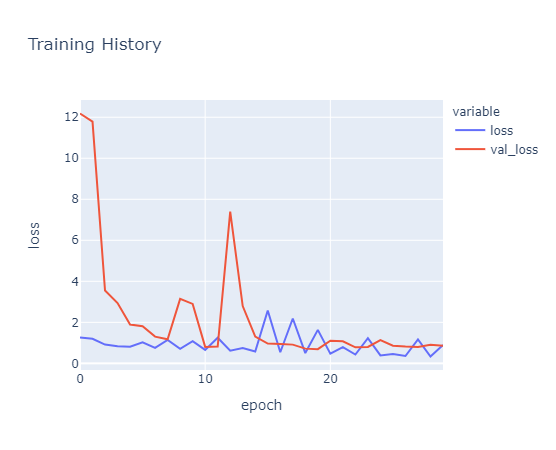

In [144]:
fig = px.line(
    history_ethnicity.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

### Loss & Accuracy

In [145]:
loss, acc = model_ethnicity.evaluate(X_test_ethnicity, y_test_ethnicity, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.6902985572814941
Test Accuracy: 0.7627952694892883


## Age Prediction

In [146]:
model_age = my_model(5,"softmax",'categorical_crossentropy')
history_age = model_age.fit(X_train_age, y_train_age, batch_size=batch_size,
                              epochs = epochs, validation_data = (X_test_age,y_test_age), 
                            steps_per_epoch= X_train_age.shape[0] // batch_size, 
                            callbacks= [early_stopping, 
                            learning_rate_reduction])

Epoch 1/30
 29/259 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4573 - loss: 2.4013

W0000 00:00:1724509643.625532     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


252/259 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5781 - loss: 1.3531

W0000 00:00:1724509645.642034     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


259/259 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5798 - loss: 1.3428 - val_accuracy: 0.1080 - val_loss: 3.7236 - learning_rate: 0.0010
Epoch 2/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 6s 922us/step - accuracy: 0.6471 - loss: 0.8562 - val_accuracy: 0.1080 - val_loss: 3.6321 - learning_rate: 0.0010
Epoch 3/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7121 - loss: 0.7361 - val_accuracy: 0.1527 - val_loss: 3.6819 - learning_rate: 0.0010
Epoch 4/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8824 - loss: 0.5945 - val_accuracy: 0.1486 - val_loss: 3.4413 - learning_rate: 0.0010
Epoch 5/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7440 - loss: 0.6621 - val_accuracy: 0.1035 - val_loss: 3.9096 - learning_rate: 0.0010
Epoch 6/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.7647 - loss: 0.8314 - val_accuracy: 0.1170 - val_loss: 3.2948 - learning_rate: 0.0010
Epoch 7/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7563 - loss: 0.6101 - val_a

### Plotting model performance

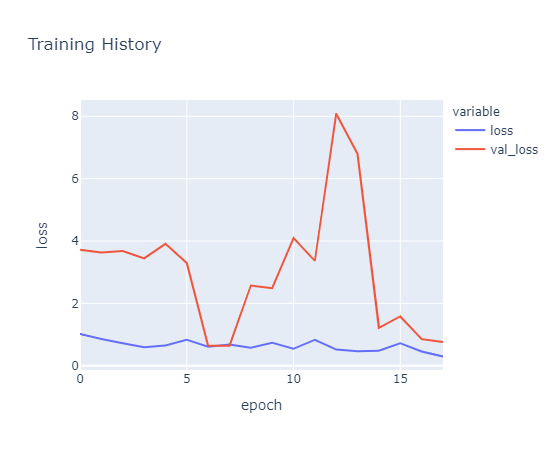

In [147]:
fig = px.line(
    history_age.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

### Loss & Accuracy

In [148]:
loss, acc = model_age.evaluate(X_test_age, y_test_age, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.641268253326416
Test Accuracy: 0.7536557912826538


# Gender Prediction

In [149]:
model_gender = my_model(2, "sigmoid", "binary_crossentropy")
history_gender = model_gender.fit(X_train_gender, y_train_gender, 
                                 batch_size = batch_size,
                                 epochs = epochs,
                                 validation_data = (X_test_gender, y_test_gender),
                                 steps_per_epoch = X_train_gender.shape[0] // batch_size, callbacks=[early_stopping,learning_rate_reduction])


Epoch 1/30
 31/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5789 - loss: 1.1584

W0000 00:00:1724509703.020509     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


257/259 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7000 - loss: 0.6749

W0000 00:00:1724509705.129132     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.7007 - loss: 0.6730 - val_accuracy: 0.4740 - val_loss: 2.3529 - learning_rate: 0.0010
Epoch 2/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 6s 907us/step - accuracy: 0.7059 - loss: 0.5530 - val_accuracy: 0.4740 - val_loss: 2.3536 - learning_rate: 0.0010
Epoch 3/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8261 - loss: 0.3768 - val_accuracy: 0.4740 - val_loss: 3.2534 - learning_rate: 0.0010
Epoch 4/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - accuracy: 0.7059 - loss: 0.4315 - val_accuracy: 0.4740 - val_loss: 3.2133 - learning_rate: 0.0010
Epoch 5/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8576 - loss: 0.3143 - val_accuracy: 0.8611 - val_loss: 0.3165 - learning_rate: 0.0010
Epoch 6/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - accuracy: 0.7647 - loss: 0.3753 - val_accuracy: 0.8597 - val_loss: 0.3156 - learning_rate: 0.0010
Epoch 7/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8667 - loss: 0.2979 - val

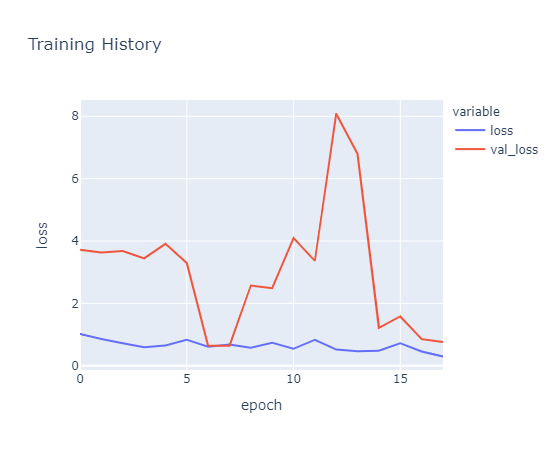

In [150]:
fx = px.line(
    history_gender.history, y=["loss", "val_loss"],
    labels = {'index':'epoch', 'value':'loss'},
    title = 'Training History')

fig.show()

### Loss and Accuracy

In [151]:
loss, acc = model_gender.evaluate(X_test_gender, y_test_gender, verbose=0)
print("Test loss: {}".format(loss))
print("Test Accuracy: {}".format(acc))

Test loss: 0.26314806938171387
Test Accuracy: 0.890326201915741


## Try it yourself!

In [152]:
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image as img_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input
import ipywidgets as widgets
from IPython.display import display

In [161]:
age_model = model_age
gender_model = model_gender
ethnicity_model = model_ethnicity

# Define ethnicity labels
ethnicity_labels = ['White', 'Black', 'Asian', 'Indian', 'Others']

# Define age groups
age_groups = ['0-2', '4-6', '8-12', '15-20', '25-32', '38-43', '48-53', '60+']

# Define gender labels
gender_labels = ['Male', 'Female']

# Function to preprocess image
def preprocess_image(image):
    img = img_preprocess.img_to_array(image)
    img = img.resize((48, 48, 1))  # Resize to 48x48
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

# Function to predict age
def predict_age(image):
    age_pred = np.argmax(age_model.predict(image)[0])
    return age_groups[age_pred]

# Function to predict gender
def predict_gender(image):
    gender_pred = np.argmax(gender_model.predict(image)[0])
    return gender_labels[gender_pred]

# Function to predict ethnicity
def predict_ethnicity(image):
    ethnicity_pred = np.argmax(ethnicity_model.predict(image)[0])
    return ethnicity_labels[ethnicity_pred]

# Create file uploader widget
uploader = widgets.FileUpload(accept='*.jpg', multiple=False)

In [162]:
# Display uploader widget
display(uploader)

FileUpload(value={}, accept='*.jpg', description='Upload')

X shape: (1, 48, 48, 1)


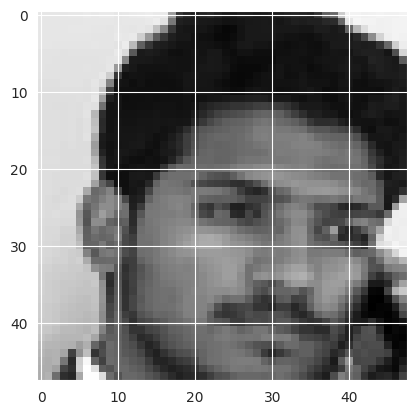

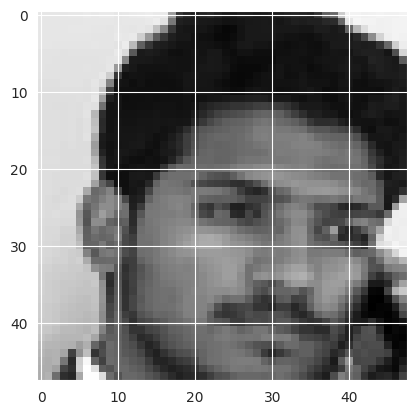

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Age: 25-32, Gender: Male, Ethnicity: Others


In [164]:
import io
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Assume 'uploader' is a widget or some form of input file handler
input_file = list(uploader.value.values())[0]
content = input_file['content']

# Load the image
uploaded_image = Image.open(io.BytesIO(content))
uploaded_image = uploaded_image.resize((48, 48))
uploaded_image_gray = uploaded_image.convert("L")

# Convert the image to an array and flatten it
image_array = np.array(uploaded_image_gray)
pixel_values = ' '.join(map(str, image_array.flatten()))

# Convert to pandas Series and process
pixel_series = pd.Series([pixel_values])
X = pixel_series.apply(lambda x: x.split(' '))
X = X.apply(lambda x: np.array(list(map(int, x))))  # Simplified int conversion
X = np.stack(X.values, axis=0)

# Reshape the array
X = X.reshape(-1, 48, 48, 1)
print("X shape:", X.shape)

# Display the image
plt.imshow(X[0].reshape(48, 48), cmap='gray')  # Explicit reshape for 2D display
plt.show()

# Normalize the pixel values
X = X / 255.0

# Display normalized image
plt.imshow(X[0].reshape(48, 48), cmap='gray')
plt.show()

# Prediction (assuming these functions are defined and models are loaded)
age = predict_age(X)
gender = predict_gender(X)
ethnicity = predict_ethnicity(X)

print(f"Predicted Age: {age}, Gender: {gender}, Ethnicity: {ethnicity}")
